In [624]:
# Import necessary modules
import os
import pandas
import numpy as np
from sklearn import preprocessing, decomposition, mixture
from copy import deepcopy
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import nibabel as ni

In [4]:
# Load scores spreadsheet

# change this to your path
path_2_sht = '/Users/jakevogel/Dropbox/Work/Projects/Villeneuve_Grant_2017/scores.xlsx'
master_df = pandas.ExcelFile(path_2_sht).parse('Sheet1')
master_df.head()

,Recipient First Name,Progress,Recorded Date,closest_visit,closest_visit_date,med_score,edu_score,total_score,Physical_activity_2,Chronic_Pain,...,gai_score,indicated_anxiety,DASS_score,apathy_score,prsev_score,extraversion,agreeableness,conscientiousness,neuroticism,openness_score
0,MTL0501,100.0,09-22-2016 10:30 AM,12M,2016-11-01,2.0,18.0,20.0,33.0,1.0,...,0.0,no,0.0,21.0,3.0,23.0,45.0,40.0,13.0,43.0
1,MTL0198,100.0,09-22-2016 10:38 AM,36M,2016-06-14,2.0,13.0,15.0,31.0,2.0,...,10.0,no,12.0,22.0,26.0,35.0,35.0,42.0,16.0,47.0
2,MTL0466,100.0,09-22-2016 10:50 AM,12M,2016-06-09,2.0,11.0,13.0,29.0,2.0,...,6.0,no,6.0,20.0,12.0,24.0,35.0,32.0,19.0,25.0
3,MTL0479,100.0,09-22-2016 11:45 AM,12M,2016-06-07,2.0,12.0,14.0,20.0,2.0,...,0.0,no,1.0,23.0,2.0,26.0,38.0,45.0,10.0,48.0
4,MTL0599,100.0,09-22-2016 11:46 AM,BL,2016-07-18,2.0,12.0,14.0,25.0,1.0,...,0.0,no,3.0,36.0,18.0,24.0,42.0,28.0,14.0,27.0


In [5]:
master_df.columns.tolist()

['Recipient First Name',
 'Progress',
 'Recorded Date',
 'closest_visit',
 'closest_visit_date',
 'med_score',
 'edu_score',
 'total_score',
 'Physical_activity_2',
 'Chronic_Pain',
 'Source',
 'Other',
 'Q8.1 - SMOKING HABITS  How would you describe your smoking experience at present?',
 'education_score',
 'working_score',
 'leisure_score',
 'num_children',
 'total_6yrs',
 'average_6yrs',
 'total_12yrs',
 'average_12yrs',
 'total_18yrs',
 'average_18yrs',
 'total_40yrs',
 'average_40yrs',
 'total_current',
 'average_current',
 'epworth_sleep_score',
 'epworth_interpretation',
 'comp1_SLPQUAL',
 'comp2_LATEN',
 'comp3_DURAT',
 'comp4_DURAT',
 'comp5_DISTB',
 'comp6_MEDS',
 'comp7_DAYDYS',
 'global_psqi',
 'sleep_quality_rating',
 'Q16.1 - EVERYDAY COGNITION (1/6)This section will focus on how you think your memory, language, and attention abilities are now, in comparison to the past.Do you think your memory is becoming worse?',
 'Q16.2 - Are you concerned because of:',
 'Q16.3 - Do yo

In [61]:
# First we achoose the variables for the outcome

psycho_stress = ['gds_score','gai_score','DASS_score','apathy_score',
 'Q16.1 - EVERYDAY COGNITION (1/6)This section will focus on how you think your memory, language, and attention abilities are now, in comparison to the past.Do you think your memory is becoming worse?']
psycho_stress2 = psycho_stress[:]
psycho_stress2.remove('apathy_score')
psycho_stress3 = psycho_stress[:]
psycho_stress3.remove('Q16.1 - EVERYDAY COGNITION (1/6)This section will focus on how you think your memory, language, and attention abilities are now, in comparison to the past.Do you think your memory is becoming worse?')
psycho_stress3.append('ECOG_score')

ps_all = psycho_stress + ['ECOG_score']
#sleep = ['epworth_sleep_score','comp1_SLPQUAL','comp2_LATEN',
#        'comp3_DURAT','comp4_DURAT','comp5_DISTB','comp6_MEDS','comp7_DAYDYS']

sleep = ['global_psqi','epworth_sleep_score']

physical = ['Chronic_Pain'] + sleep

In [96]:
big_df = master_df[(ps_all + physical)]
big_df.index = master_df['Recipient First Name']
big_df.head()

,gds_score,gai_score,DASS_score,apathy_score,"Q16.1 - EVERYDAY COGNITION (1/6)This section will focus on how you think your memory, language, and attention abilities are now, in comparison to the past.Do you think your memory is becoming worse?",ECOG_score,Chronic_Pain,global_psqi,epworth_sleep_score
Recipient First Name,,,,,,,,,
MTL0501,0.0,0.0,0.0,21.0,2.0,1.384615,1.0,4.0,1.0
MTL0198,2.0,10.0,12.0,22.0,1.0,1.128205,2.0,6.0,8.0
MTL0466,0.0,6.0,6.0,20.0,1.0,1.282051,2.0,6.0,6.0
MTL0479,1.0,0.0,1.0,23.0,1.0,1.076923,2.0,13.0,2.0
MTL0599,4.0,0.0,3.0,36.0,3.0,1.384615,1.0,5.0,12.0


In [74]:
len(big_df1)

261

In [97]:
# get rid of 999s in a lazy way
for x in big_df.index:
    for y in big_df.columns:
        if big_df.ix[x,y] == 999.0 or big_df.ix[x,y] == 999:
            big_df.ix[x,y] = np.nan
print('dropping %s subjects with missing values'%(
            len(big_df) - len(big_df.dropna())))
big_df1 = big_df.dropna()

//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


dropping 19 subjects with missing values


In [89]:
# add headache
ha = pandas.ExcelFile('/Users/jakevogel/Dropbox/Team 1/Scores_with_headache.xlsx')
ha = pandas.ExcelFile('/Users/jakevogel/Dropbox/Team 1/Scores_with_headache.xlsx').parse(ha.sheet_names[0])

In [90]:
ha.index = ha[:][ha.columns[0]]
ha.index

Index(['MTL0501', 'MTL0198', 'MTL0466', 'MTL0479', 'MTL0599', 'MTL0462',
       'MTL0552', 'MTL0211', 'MTL0257', 'MTL0225',
       ...
       'MTL0436', 'MTL0207', 'MTL0205', 'MTL0279', 'MTL0528', 'MTL0377',
       'MTL0349', 'MTL0589', 'MTL0572', 'MTL0086'],
      dtype='object', name='Recipient First Name', length=279)

In [91]:
ha.columns

Index(['Recipient First Name', 'Progress', 'Recorded Date', 'closest_visit',
       'closest_visit_date', 'med_score', 'edu_score', 'total_score',
       'Physical_activity_2', 'Chronic_Pain', 'Source', 'Other',
       'Q8.1 - SMOKING HABITS  How would you describe your smoking experience at present?',
       'education_score', 'working_score', 'leisure_score', 'num_children',
       'total_6yrs', 'average_6yrs', 'total_12yrs', 'average_12yrs',
       'total_18yrs', 'average_18yrs', 'total_40yrs', 'average_40yrs',
       'total_current', 'average_current', 'epworth_sleep_score',
       'epworth_interpretation', 'comp1_SLPQUAL', 'comp2_LATEN', 'comp3_DURAT',
       'comp4_HSE', 'comp5_DISTB', 'comp6_MEDS', 'comp7_DAYDYS', 'global_psqi',
       'sleep_quality_rating',
       'Q16.1 - EVERYDAY COGNITION (1/6)This section will focus on how you think your memory, language, and attention abilities are now, in comparison to the past.Do you think your memory is becoming worse?',
       'Q16.2 

In [98]:
for sub in big_df1.index:
    if sub in ha.index:
        big_df1.ix[sub,'headache'] = ha.ix[sub,'9_headache of general_physical']

//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/indexing.py:301: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(new_indexer, value)
//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

In [99]:
len(big_df1)

261

In [86]:
big_df1.dropna(inplace=True)

//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [88]:
len(big_df1)

245

In [100]:
big_df1.to_csv('/Users/jakevogel/Dropbox/Work/Projects/Villeneuve_Grant_2017/all_ready.csv')

In [32]:
# Now lets work with Outcome 2: Psycho_stress

ps_df = master_df[psycho_stress]
ps_df.head()

,gds_score,gai_score,DASS_score,apathy_score,"Q16.1 - EVERYDAY COGNITION (1/6)This section will focus on how you think your memory, language, and attention abilities are now, in comparison to the past.Do you think your memory is becoming worse?"
0,0.0,0.0,0.0,21.0,2.0
1,2.0,10.0,12.0,22.0,1.0
2,0.0,6.0,6.0,20.0,1.0
3,1.0,0.0,1.0,23.0,1.0
4,4.0,0.0,3.0,36.0,3.0


In [33]:
# get rid of 999s in a lazy way
for x in ps_df.index:
    for y in ps_df.columns:
        if ps_df.ix[x,y] == 999.0 or ps_df.ix[x,y] == 999:
            ps_df.ix[x,y] = np.nan
print('dropping %s subjects with missing values'%(
            len(ps_df) - len(ps_df.dropna())))
ps_df1 = ps_df.dropna()

//anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


dropping 19 subjects with missing values


In [34]:
# Normalize data
ps_df_norm = preprocessing.scale(ps_df1)

In [38]:
fa_solution = decomposition.FactorAnalysis(n_components=ps_df_norm.shape[1]).fit(ps_df_norm)

In [42]:
fa_solution.components_

array([[ 0.68918329,  0.76684748,  0.69712661,  0.51782311,  0.41623065],
       [-0.06271588,  0.12455666,  0.16635242, -0.23494705, -0.24518412],
       [ 0.        , -0.        , -0.        ,  0.        , -0.        ],
       [ 0.        ,  0.        , -0.        , -0.        ,  0.        ],
       [-0.        ,  0.        , -0.        ,  0.        ,  0.        ]])

In [47]:
fa_solution.components_

array([[ 0.68918329,  0.76684748,  0.69712661,  0.51782311,  0.41623065],
       [-0.06271588,  0.12455666,  0.16635242, -0.23494705, -0.24518412],
       [ 0.        , -0.        , -0.        ,  0.        , -0.        ],
       [ 0.        ,  0.        , -0.        , -0.        ,  0.        ],
       [-0.        ,  0.        , -0.        ,  0.        ,  0.        ]])

In [48]:
ps_df1.to_csv('/Users/jakevogel/Dropbox/Work/Projects/Villeneuve_Grant_2017/outcome2_ready')

In [53]:
# do the same for sleep and outcome 2

sdf = master_df[sleep]
sdf

,epworth_sleep_score,comp1_SLPQUAL,comp2_LATEN,comp3_DURAT,comp4_DURAT,comp5_DISTB,comp6_MEDS,comp7_DAYDYS
0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0
1,8.0,1.0,1.0,0.0,1.0,1.0,2.0,0.0
2,6.0,0.0,2.0,0.0,2.0,1.0,0.0,1.0
3,2.0,2.0,3.0,3.0,2.0,2.0,1.0,0.0
4,12.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0
5,1.0,2.0,1.0,0.0,1.0,1.0,0.0,1.0
6,6.0,2.0,2.0,2.0,3.0,1.0,2.0,0.0
7,10.0,2.0,3.0,1.0,1.0,2.0,0.0,1.0
8,2.0,2.0,0.0,2.0,2.0,1.0,0.0,1.0
9,6.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0


In [55]:
# get rid of 999s in a lazy way
for x in sdf.index:
    for y in sdf.columns:
        if sdf.ix[x,y] == 999.0 or sdf.ix[x,y] == 999:
            sdf.ix[x,y] = np.nan
print('dropping %s subjects with missing values'%(
            len(sdf) - len(sdf.dropna())))
sdf1 = sdf.dropna()

dropping 8 subjects with missing values


In [60]:
sdf.index

RangeIndex(start=0, stop=280, step=1)

In [58]:
sdf1.to_csv('/Users/jakevogel/Dropbox/Work/Projects/Villeneuve_Grant_2017/sleep_ready')

In [ ]:
### TIME TO COMPUTE THE ACTUAL FINAL SCORES

In [102]:
out2_pth='/Users/jakevogel/Dropbox/Work/Projects/Villeneuve_Grant_2017/outcome2_scores.xls'
out3_pth='/Users/jakevogel/Dropbox/Work/Projects/Villeneuve_Grant_2017/outcome3_scores.xls'

out2 = pandas.ExcelFile(out2_pth)
out2 = pandas.ExcelFile(out2_pth).parse(out2.sheet_names[0])

out3 = pandas.ExcelFile(out3_pth)
out3 = pandas.ExcelFile(out3_pth).parse(out3.sheet_names[0])



In [104]:
out2.columns.tolist()

['Recipient First Name',
 'gds_score',
 'gai_score',
 'DASS_score',
 'apathy_score',
 'Q16.1 - EVERYDAY COGNITION (1/6)This section will focus on how you think your memory, language, and attention abilities are now, in comparison to the past.Do you think your memory is becoming worse?',
 'ECOG_score',
 'Chronic_Pain',
 'global_psqi',
 'epworth_sleep_score',
 'headache',
 'Factor1',
 'Factor2',
 'Factor3',
 'Factor4',
 'Factor5',
 'Prin1',
 'Prin2',
 'Prin3',
 'Prin4',
 'Prin5',
 'Factor1 2',
 'Factor2 2']

In [111]:
out2.pcs = out2[out2.columns[-7:-2]]
out2.fax = out2[out2.columns[-2:]]

In [112]:
out3.pcs = out3[out3.columns[-6:-2]]
out3.fax = out3[out3.columns[-2:]]

In [113]:
43.918/80.474

0.5457414817208042

In [114]:
out2.pcs.weights = [.55269, .16442, .12451, .10392, .05447]
out2.fax.weights = [(43.918/80.474), (36.556/80.474)]

In [115]:
out3.pcs.weights = [.30290, .28705, .22581, .18424]
out3.fax.weights = [(11.415/22.440), (11.025/22.440)]

In [124]:
a = out2.pcs.loc[0].values
b = out2.pcs.weights
a* b

array([-0.70852041,  0.05413608,  0.1057451 , -0.0451887 , -0.01544761])

In [125]:
out2.weighted_pcs = out2.pcs * out2.pcs.weights
out2.weighted_fax = out2.fax * out2.fax.weights

In [126]:
out3.weighted_pcs = out3.pcs * out3.pcs.weights
out3.weighted_fax = out3.fax * out3.fax.weights

In [133]:
out2.final_pca = out2.weighted_pcs.mean(axis=1)
out2.final_fa = out2.weighted_fax.mean(axis=1)

In [134]:
out3.final_pca = out3.weighted_pcs.mean(axis=1)
out3.final_fa = out3.weighted_fax.mean(axis=1)

In [193]:
z_fa2 = (out2.final_fa / out2.final_fa.mean()) / out2.final_fa.std()
z_fa3 = (out3.final_fa / out3.final_fa.mean()) / out3.final_fa.std()

log_fa2 = preprocessing.scale(out2.final_fa.dropna())
log_fa3 = preprocessing.scale(out3.final_fa.dropna())

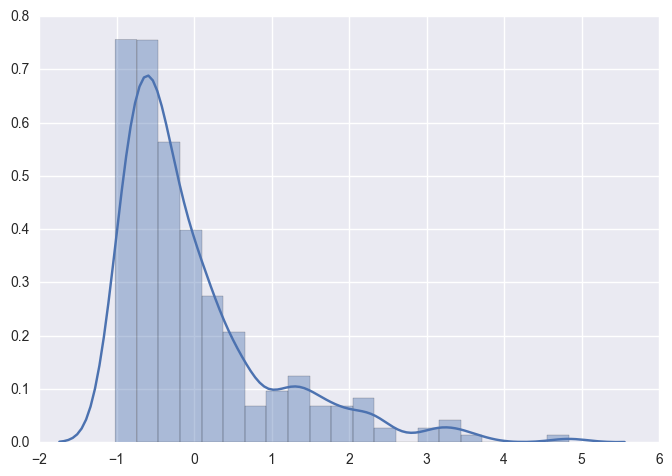

In [249]:
plt.close()
sns.distplot(log_fa2)
#plt.plot([-0.5, -0.5], [0, 3], linewidth=2)
plt.show()

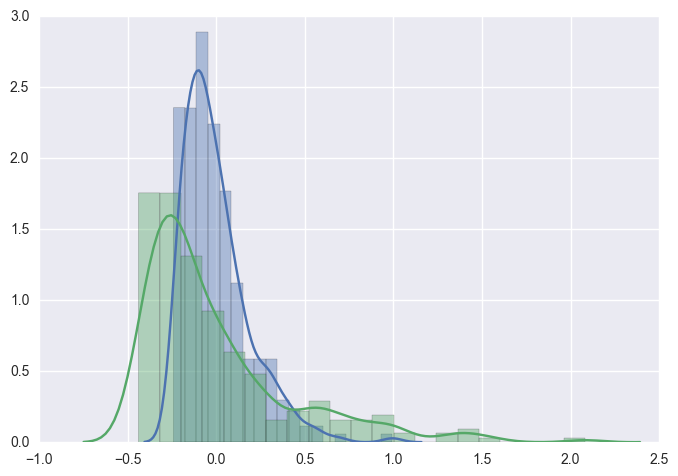

In [211]:
plt.close()
sns.distplot(out2.final_pca)
sns.distplot(out2.final_fa)
#plt.plot([-0.5, -0.5], [0, 3], linewidth=2)
plt.show()

In [204]:
np.min([x for x in out2.final_fa if x < pca2_top_quartile])

-0.43880621026822397

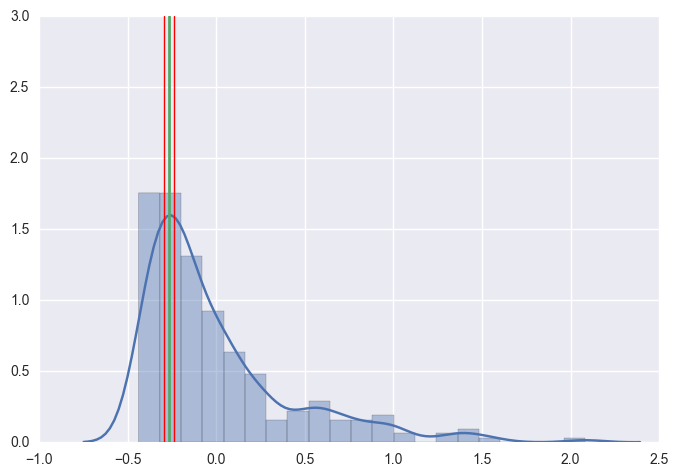

In [366]:
# quartiles
fa2_top_quartile = sorted(out2.final_fa)[int(len(out2.final_fa) * .30)]
se = out2.final_fa.std() / (sqrt(len(out2.final_fa)))
se1 = fa2_top_quartile + se
se2 = fa2_top_quartile - se

plt.close()
sns.distplot(out2.final_fa)
plt.plot([fa2_top_quartile, fa2_top_quartile], [0, 3], linewidth=2)
plt.plot([se1,se1], [0, 3], linewidth=1, color='r')
plt.plot([se2,se2], [0, 3], linewidth=1, color='r')
plt.show()

In [367]:
se2

-0.29321684880256554

In [391]:
sorted(out3.final_fa)[int(len(out3.final_fa) * .70)]

-0.067144743967515602

In [386]:
int(len(out3.final_fa) * .70)

182

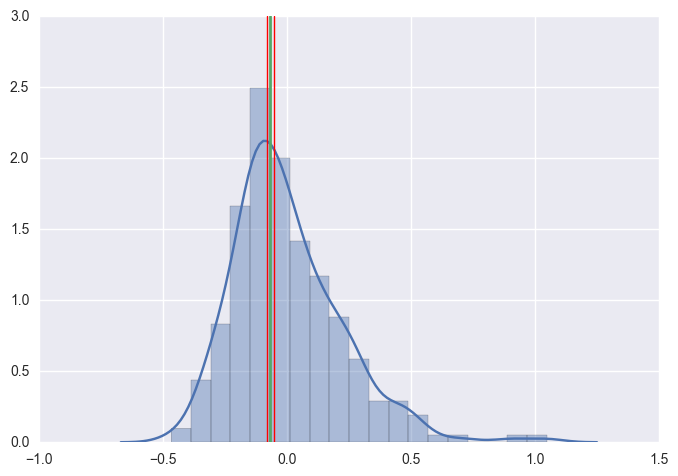

In [384]:
fa3_top_quartile = sorted(out3.final_fa)[int(len(out3.final_fa) * .70)]
se = out3.final_fa.std() / (sqrt(len(out3.final_fa)))
se3_1 = fa3_top_quartile + se
se3_2 = fa3_top_quartile - se

plt.close()
sns.distplot(out3.final_fa.dropna())
plt.plot([fa3_top_quartile, fa3_top_quartile], [0, 3], linewidth=2)
plt.plot([se3_1,se3_1], [0, 3], linewidth=1, color='r')
plt.plot([se3_2,se3_2], [0, 3], linewidth=1, color='r')
plt.show()


In [144]:
.22 * 261

57.42

In [175]:
to_add_ids = [out2.final_pca,out2.final_fa,out3.final_pca,out3.final_fa]
for ser in to_add_ids:
    ser.index = big_df.index

In [212]:
# Load Hazal's scores
hazal_pth='/Users/jakevogel/Dropbox/Team 1/Average_z_scores.xlsx'

hazal = pandas.ExcelFile(hazal_pth)
hazal = pandas.ExcelFile(hazal_pth).parse(hazal.sheet_names[0])

In [213]:
hazal.index = hazal.recipientFirstName

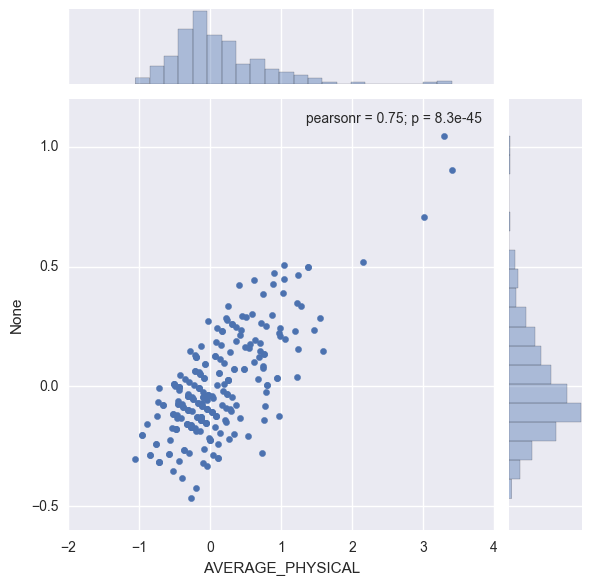

In [252]:
plt.close()
sns.jointplot(hazal.AVERAGE_PHYSICAL.loc[out2.final_pca.index],out3.final_fa)
plt.show()

In [253]:
sqrt(.75)

0.8660254037844386

In [241]:
# Pierres people 
pierre = pandas.read_csv('/Users/jakevogel/Dropbox/Team 1/psychological_wellbeing.csv')
pids = pierre[pierre['psychological_wellbeing']<2]['id']


In [236]:
jids = out2.final_fa[out2.final_fa<se2].index

In [243]:
len(set(pids) & set(jids))

37

In [246]:
len(set(pids) & set(jids)) / len(pids)

0.8604651162790697

In [247]:
len(set(pids) & set(jids)) / len(jids)

0.6727272727272727

In [256]:
lifestyle = pandas.ExcelFile('/Users/jakevogel/Downloads/Retreat_Lifestyle.xlsx').parse('Sheet2')

In [260]:
lifestyle.index = lifestyle.recipientFirstName

In [263]:
sls = preprocessing.scale(lifestyle[lifestyle.columns[1:]].dropna())

In [266]:
from sklearn.cross_decomposition import CCA
CCA?

In [267]:
cca_res = CCA().fit(sls)

TypeError: fit() missing 1 required positional argument: 'Y'

In [269]:
lifestyle.columns

Index(['recipientFirstName', 'diet_score', 'physact_score', 'pain_yes_No',
       'pain_intensity', 'education_score', 'working_score', 'leisure_score',
       'epworth_sleepiness_score', 'global_psqi', 'scd', 'ECOG_score',
       'social_score', 'gds_score', 'gai_score', 'DASS_score', 'apathy_score',
       'prsev_score', 'extraversion_score', 'agreeableness_score',
       'conscientiousness_score', 'neuroticism_score', 'openness_score'],
      dtype='object')

In [323]:
test_pth = '/Users/jakevogel/Dropbox/Work/Projects/Villeneuve_Grant_2017/PLS/Retreat_Test.xls'
test = pandas.ExcelFile(test_pth)
test = pandas.ExcelFile(test_pth).parse(test.sheet_names[0])

train_pth = '/Users/jakevogel/Dropbox/Work/Projects/Villeneuve_Grant_2017/PLS/Retreat_Train.xls'
train = pandas.ExcelFile(train_pth)
train = pandas.ExcelFile(train_pth).parse(train.sheet_names[0])

y_pth = '/Users/jakevogel/Dropbox/Work/Projects/Villeneuve_Grant_2017/PLS/PLS Y Loadings.xls'
plsy = pandas.ExcelFile(y_pth)
plsy = pandas.ExcelFile(y_pth).parse(plsy.sheet_names[0])

x_pth = '/Users/jakevogel/Dropbox/Work/Projects/Villeneuve_Grant_2017/PLS/pls_x_loadings.xls'
plsx = pandas.ExcelFile(x_pth)
plsx = pandas.ExcelFile(x_pth).parse(plsx.sheet_names[0])

In [338]:
xcols = [1,2,5,6,7,12,17,18,19,20,21]
ycols = [11,13,14,15,16]
testx = test.ix[:,xcols]
testy = test.ix[:,ycols]
trainx = train.ix[:,xcols]
trainy = train.ix[:,ycols]

In [339]:
scaler = preprocessing.StandardScaler().fit(trainx)
testx = pandas.DataFrame(scaler.transform(testx),index = testx.index,columns=testx.columns)

In [340]:

testx = testx.sort_index(1)
testx.head()

,agreeableness_score,conscientiousness_score,diet_score,education_score,extraversion_score,leisure_score,neuroticism_score,physact_score,prsev_score,social_score,working_score
0,-1.057832,0.610301,1.526364,-0.150881,1.055971,-1.182166,-0.771452,0.827899,-1.677210,0.205375,0.219611
1,1.385610,0.798085,0.189522,1.174409,0.190940,-0.840148,0.490574,-1.542247,0.218465,-0.853600,1.608957
2,0.941348,0.234731,-0.144689,0.020124,1.055971,-0.009534,0.017314,0.827899,-1.108508,-0.508594,-0.955990
3,1.385610,1.361440,0.189522,-0.022627,0.882965,1.602836,-1.086959,0.489307,-1.203291,-0.733806,1.822703
4,0.497086,-1.079763,2.194785,-0.279135,-1.193110,-0.693569,2.068107,-0.865062,-0.445021,0.229334,-1.810973


In [341]:
plsx.index = plsx['X Variables']

In [342]:
plsx = plsx.sort_index(0)
plsx

,X Variables,X Loadings 1,X Loadings 2,X Loadings 3,X Loadings 4,X Loadings 5
X Variables,,,,,,
agreeableness_score,agreeableness_score,-0.374493,-0.014775,0.423085,0.058186,-0.346179
conscientiousness_score,conscientiousness_score,-0.422524,0.495722,0.177479,-0.263407,-0.119692
diet_score,diet_score,-0.116584,0.242839,0.106667,0.144606,0.523410
education_score,education_score,0.020916,-0.162322,-0.397102,-0.305441,0.240660
extraversion_score,extraversion_score,-0.210855,0.341366,-0.553551,-0.104722,-0.227000
leisure_score,leisure_score,-0.139120,0.338793,0.181082,0.626881,0.045915
neuroticism_score,neuroticism_score,0.513980,0.374413,0.135712,-0.235669,0.068704
physact_score,physact_score,-0.167663,0.363926,-0.206319,0.401968,0.469216
prsev_score,prsev_score,0.471487,0.359442,0.187669,0.109806,-0.054920


In [344]:
predictor_x = testx * plsx['X Loadings 1'].values

In [345]:
plt.close()
sns.jointplot(predictor_x,

,agreeableness_score,conscientiousness_score,diet_score,education_score,extraversion_score,leisure_score,neuroticism_score,physact_score,prsev_score,social_score,working_score
0,0.396150,-0.257867,-0.177950,-0.003156,-0.222657,0.164462,-0.396511,-0.138808,-0.790783,0.060909,-0.006378
1,-0.518901,-0.337210,-0.022095,0.024564,-0.040261,0.116881,0.252145,0.258577,0.103003,-0.253153,-0.046726
2,-0.352528,-0.099180,0.016868,0.000421,-0.222657,0.001326,0.008899,-0.138808,-0.522647,-0.150835,0.027763
3,-0.518901,-0.575241,-0.022095,-0.000473,-0.186178,-0.222986,-0.558675,-0.082039,-0.567337,-0.217626,-0.052933
4,-0.186155,0.456226,-0.255877,-0.005838,0.251574,0.096489,1.062966,0.145039,-0.209822,0.068014,0.052593
5,-0.352528,0.297539,-0.022095,-0.003603,-0.040261,0.008124,0.495392,0.031500,0.549897,0.143332,0.018452
6,-0.352528,-0.337210,-0.177950,-0.004050,-0.040261,0.048908,-0.801921,-0.025269,-0.612026,-0.548741,0.027763
7,-0.435715,-0.416554,-0.100022,-0.003156,-0.003781,-0.066647,-0.153265,0.031500,-0.790783,-0.274470,0.040178
8,-0.186155,0.218195,-0.061059,-0.000473,0.105656,-0.161810,1.630541,-0.195577,0.773344,-0.086648,0.027763
9,-0.186155,-0.178523,0.133759,-0.000473,-0.149699,0.055705,0.171063,0.031500,0.415829,0.511396,0.043281


In [1246]:
pls_jnk = pandas.ExcelFile(
        '/Users/jakevogel/Dropbox/Work/Projects/Villeneuve_Grant_2017/PLS_jnk.xls'
        )
pls_jnk = pandas.ExcelFile(
        '/Users/jakevogel/Dropbox/Work/Projects/Villeneuve_Grant_2017/PLS_jnk.xls'
        ).parse(pls_jnk.sheet_names[0])

In [1249]:
pls_jnk.index = pls_jnk[pls_jnk.columns[0]]

In [1251]:
for sub in pls_jnk.index:
    if sub in cog.index:
        pls_jnk.ix[sub,'outcome1'] = cog.ix[sub,'Cog_Continuous']

In [1252]:
pls_jnk.to_excel('/Users/jakevogel/Dropbox/Work/Projects/Villeneuve_Grant_2017/PLS_jnk.xls')

In [557]:
tau = pandas.ExcelFile('/Users/jakevogel/Downloads/pet_nav_and_tau_groups.xlsx').parse('TAU')
nav = pandas.ExcelFile('/Users/jakevogel/Downloads/pet_nav_and_tau_groups.xlsx').parse('NAV')

In [558]:
tau.mtlid = [x[3:10] for x in tau.index]

In [559]:
tau.index = tau.mtlid

In [560]:
tau[tau.columns[60:89]]

,ctx-lh-caudalanteriorcingulate,ctx-lh-caudalmiddlefrontal,ctx-lh-cuneus,ctx-lh-entorhinal,ctx-lh-fusiform,ctx-lh-inferiorparietal,ctx-lh-inferiortemporal,ctx-lh-isthmuscingulate,ctx-lh-lateraloccipital,ctx-lh-lateralorbitofrontal,...,ctx-lh-postcentral,ctx-lh-posteriorcingulate,ctx-lh-precentral,ctx-lh-precuneus,ctx-lh-rostralanteriorcingulate,ctx-lh-rostralmiddlefrontal,ctx-lh-superiorfrontal,ctx-lh-superiorparietal,ctx-lh-superiortemporal,ctx-lh-supramarginal
MTL0380,1.2685,1.2172,1.1674,1.2662,1.0975,1.2258,1.1556,1.0850,1.1341,1.0879,...,1.0980,1.2862,1.1260,1.2616,1.1377,1.1745,1.2662,1.2155,1.0287,1.1235
MTL0574,1.1559,1.1510,1.2941,1.2320,1.1975,1.3574,1.2824,1.1549,1.2068,1.1690,...,1.0824,1.1415,1.0787,1.2364,1.1935,1.3040,1.1397,1.1909,1.1674,1.2210
MTL0018,1.1353,1.1390,1.4544,1.4834,1.3118,1.3878,1.3488,1.3039,1.3829,1.1721,...,1.1086,1.2043,1.1233,1.3579,1.0757,1.1174,1.0647,1.2511,1.1999,1.2632
MTL0414,1.0478,1.1455,1.0362,0.9129,1.1071,1.1730,1.2100,1.1947,1.1231,1.1920,...,1.1142,1.3133,1.1622,1.2984,1.0050,1.1185,1.0762,1.1516,1.0614,1.2040
MTL0005,1.0713,1.0013,1.0582,1.0202,1.1152,1.1006,1.1641,1.0724,1.0842,1.1493,...,0.9614,1.1400,0.9115,1.1260,1.0624,0.9668,0.9632,1.0752,1.0501,1.0730
MTL0085,1.2413,1.1223,1.1899,1.1144,1.1373,1.2392,1.1565,1.1920,1.1101,1.1724,...,1.0167,1.2293,1.0473,1.2077,1.0848,1.1788,1.0427,1.1261,1.0907,1.1819
MTL0086,1.1291,1.1627,1.2255,1.0788,1.1922,1.2821,1.2304,1.1168,1.1470,1.0814,...,1.1220,1.2167,1.0955,1.2188,1.0860,1.1102,1.0989,1.1843,1.1679,1.2549
MTL0179,1.1376,1.1520,1.2653,1.2130,1.3154,1.3455,1.3217,1.2549,1.2329,1.2181,...,1.1049,1.1966,1.1113,1.2917,1.0586,1.1423,1.0704,1.2174,1.1656,1.2985
MTL0186,1.0527,1.0648,1.1654,1.0625,1.1472,1.1583,1.1280,1.0889,1.1259,1.0775,...,1.0441,1.1917,1.0380,1.1496,0.9889,1.0149,1.0416,1.1438,1.0083,1.0873
MTL0212,1.1855,1.0423,1.0753,0.8680,1.0691,1.1519,1.1855,1.0753,1.1193,1.1779,...,1.0603,1.2282,1.0517,1.1416,1.1511,1.1610,1.0545,1.0721,1.1372,1.1451


In [589]:
indata = tau
dv = out2.final_fa
lh_cols = [60,89]
rh_cols = [95,-4]
lh_labs = labels.loc[labels.index[:29]][labels.columns[0]].tolist()
rh_labs = labels.loc[labels.index[39:-12]][labels.columns[0]].tolist()
out2_tau = run_correlations(indata,dv,lh_cols,rh_cols,lh_labs,rh_labs)

In [591]:
indata = tau
dv = out3.final_fa
lh_cols = [60,89]
rh_cols = [95,-4]
lh_labs = labels.loc[labels.index[:29]][labels.columns[0]].tolist()
rh_labs = labels.loc[labels.index[39:-12]][labels.columns[0]].tolist()
out3_tau = run_correlations(indata,dv,lh_cols,rh_cols,lh_labs,rh_labs)

In [596]:
cog_pth = '/Users/jakevogel/Downloads/Cognitive_Outcome.xlsx'
cog = pandas.ExcelFile(cog_pth)
cog.sheet_names

['Cog_All', 'Cog_Online_Platform']

In [599]:
cog_pth = '/Users/jakevogel/Downloads/Cognitive_Outcome.xlsx'
cog = pandas.ExcelFile(cog_pth)
cog = pandas.ExcelFile(cog_pth).parse(cog.sheet_names[1])
cog.index = cog[:][cog.columns[0]]
cog.head()

,PSCID of RBANS_BL00,CandID of RBANS_BL00,Visit_label of RBANS_BL00,Date_taken of RBANS_BL00,Candidate_Age of RBANS_BL00,Age_years of RBANS_BL00,Cog_Continuous,Cog_Binary
PSCID of RBANS_BL00,,,,,,,,
MTL0003,MTL0003,746832,NAPBL00,41179,842.8,70.2,0.368421,1
MTL0005,MTL0005,425566,NAPBL00,41187,744.9,62.1,-0.833333,0
MTL0008,MTL0008,122650,PREBL00,41295,885.0,73.8,0.894737,1
MTL0015,MTL0015,534153,NAPBL00,41207,759.7,63.3,-2.500000,0
MTL0018,MTL0018,624956,NAPBL00,41211,829.5,69.1,-1.388889,0


In [602]:
out1 = cog['Cog_Continuous']

In [604]:
indata = tau
dv = out1
lh_cols = [60,89]
rh_cols = [95,-4]
lh_labs = labels.loc[labels.index[:29]][labels.columns[0]].tolist()
rh_labs = labels.loc[labels.index[39:-12]][labels.columns[0]].tolist()
out1_tau = run_correlations(indata,dv,lh_cols,rh_cols,lh_labs,rh_labs)

In [606]:
out1_tau

,rho,p_rho,r,p_r,label
ctx-lh-caudalanteriorcingulate,0.175807,0.390298,-0.10887,0.588818,1
ctx-lh-caudalmiddlefrontal,0.305767,0.128742,0.116421,0.563069,2
ctx-lh-cuneus,-0.15478,0.450263,0.048194,0.811329,3
ctx-lh-entorhinal,-0.0420559,0.838364,-0.105698,0.599786,4
ctx-lh-fusiform,-0.166845,0.41528,-0.018748,0.92605,5
ctx-lh-inferiorparietal,-0.0427453,0.835749,0.119691,0.552079,6
ctx-lh-inferiortemporal,-0.115481,0.574275,0.0824619,0.682608,7
ctx-lh-isthmuscingulate,0.0330932,0.872497,0.412485,0.032504,8
ctx-lh-lateraloccipital,-0.0334379,0.87118,0.154175,0.442596,9
ctx-lh-lateralorbitofrontal,0.136509,0.50608,0.11736,0.559902,10


In [609]:
nav.index = [x[3:10] for x in nav.index]

In [612]:
nav.columns[94:-4]

Index(['ctx-rh-caudalanteriorcingulate', 'ctx-rh-caudalmiddlefrontal',
       'ctx-rh-cuneus', 'ctx-rh-entorhinal', 'ctx-rh-fusiform',
       'ctx-rh-inferiorparietal', 'ctx-rh-inferiortemporal',
       'ctx-rh-isthmuscingulate', 'ctx-rh-lateraloccipital',
       'ctx-rh-lateralorbitofrontal', 'ctx-rh-lingual',
       'ctx-rh-medialorbitofrontal', 'ctx-rh-middletemporal',
       'ctx-rh-parahippocampal', 'ctx-rh-paracentral',
       'ctx-rh-parsopercularis', 'ctx-rh-parsorbitalis',
       'ctx-rh-parstriangularis', 'ctx-rh-pericalcarine', 'ctx-rh-postcentral',
       'ctx-rh-posteriorcingulate', 'ctx-rh-precentral', 'ctx-rh-precuneus',
       'ctx-rh-rostralanteriorcingulate', 'ctx-rh-rostralmiddlefrontal',
       'ctx-rh-superiorfrontal', 'ctx-rh-superiorparietal',
       'ctx-rh-superiortemporal', 'ctx-rh-supramarginal'],
      dtype='object')

In [911]:
indata = nav
dv = out1
lh_cols = [59,88]
rh_cols = [94,-4]
lh_labs = labels.loc[labels.index[:29]][labels.columns[0]].tolist()
rh_labs = labels.loc[labels.index[39:-12]][labels.columns[0]].tolist()
out1_nav = run_correlations(indata,dv,lh_cols,rh_cols,lh_labs,rh_labs,True)

In [913]:
indata = nav
dv = out2.final_fa
lh_cols = [59,88]
rh_cols = [94,-4]
lh_labs = labels.loc[labels.index[:29]][labels.columns[0]].tolist()
rh_labs = labels.loc[labels.index[39:-12]][labels.columns[0]].tolist()
out2_nav = run_correlations(indata,dv,lh_cols,rh_cols,lh_labs,rh_labs,True)

In [914]:
indata = nav
dv = out3.final_fa
lh_cols = [59,88]
rh_cols = [94,-4]
lh_labs = labels.loc[labels.index[:29]][labels.columns[0]].tolist()
rh_labs = labels.loc[labels.index[39:-12]][labels.columns[0]].tolist()
out3_nav = run_correlations(indata,dv,lh_cols,rh_cols,lh_labs,rh_labs,True)

In [915]:
indata = tau
dv = out1
lh_cols = [60,89]
rh_cols = [95,-4]
lh_labs = labels.loc[labels.index[:29]][labels.columns[0]].tolist()
rh_labs = labels.loc[labels.index[39:-12]][labels.columns[0]].tolist()
out1_tau = run_correlations(indata,dv,lh_cols,rh_cols,lh_labs,rh_labs,True)

In [916]:
indata = tau
dv = out2.final_fa
lh_cols = [60,89]
rh_cols = [95,-4]
lh_labs = labels.loc[labels.index[:29]][labels.columns[0]].tolist()
rh_labs = labels.loc[labels.index[39:-12]][labels.columns[0]].tolist()
out2_tau = run_correlations(indata,dv,lh_cols,rh_cols,lh_labs,rh_labs,True)

In [917]:
indata = tau
dv = out3.final_fa
lh_cols = [60,89]
rh_cols = [95,-4]
lh_labs = labels.loc[labels.index[:29]][labels.columns[0]].tolist()
rh_labs = labels.loc[labels.index[39:-12]][labels.columns[0]].tolist()
out3_tau = run_correlations(indata,dv,lh_cols,rh_cols,lh_labs,rh_labs,True)

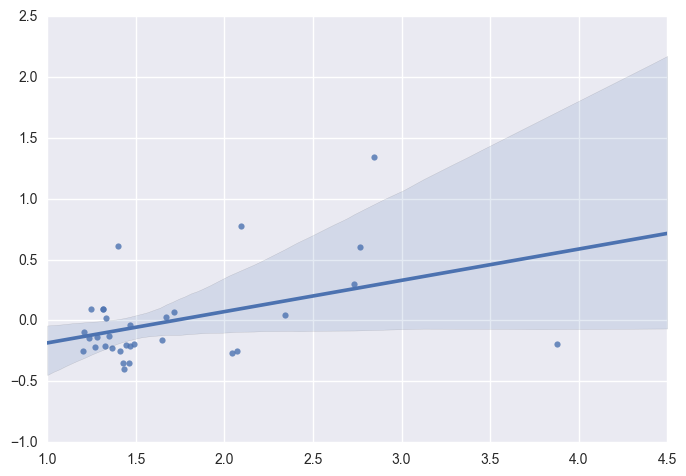

In [620]:
nan_subs = [x for x in out2.final_fa[nav.index].index if not pandas.notnull(
                                                            out2.final_fa[nav.index].loc[x]
                                                                        )]
plt.close()
sns.regplot(nav['ctx-rh-precuneus'].drop(nan_subs).values, 
            out2.final_fa[nav.index].drop(nan_subs).values)
plt.show()

In [727]:
plt.hist?

In [726]:
sns.distplot?

In [730]:
stats.spearmanr?

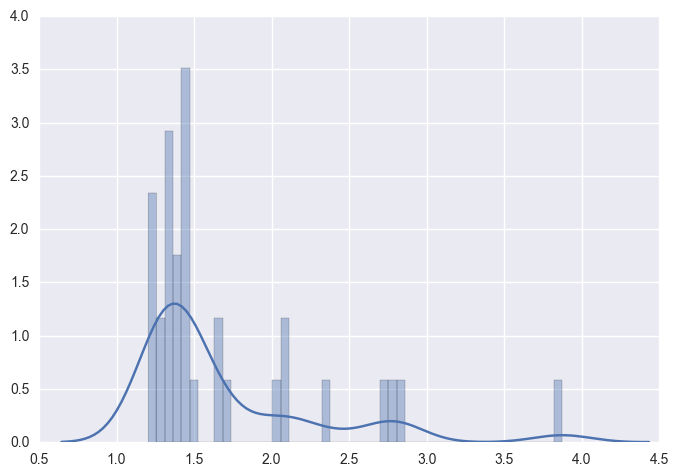

In [731]:
plt.close()
sns.distplot(nav['ctx-rh-precuneus'].drop(nan_subs).values,bins=50)
plt.show()

In [910]:
def run_correlations(indata,dv,lh_cols,rh_cols,lh_labs,rh_labs,bootstrap=False):
    # assumes ids are consistent between indata and dv
    # indata is a dataframe, dv is a pandas series
    # lh cols is a list of two integers representing the range of columns in indata of rois you
    #     want to use. Same with rh, but on the other side
    # lh_labs and rh_labs are lists of integers representing the dkt atlas 
    #     labels corresponding to ROIs in lh_cols and rh_cols
    
    # left hemisphere
    if bootstrap:
        res_l = pandas.DataFrame(index = indata.columns[lh_cols[0]:lh_cols[1]], 
                             columns = ['rho','p_rho','r','p_r','permuted_p'])
    else:
        res_l = pandas.DataFrame(index = indata.columns[lh_cols[0]:lh_cols[1]], 
                             columns = ['rho','p_rho','r','p_r'])
    
    # id nans
    if not pandas.notnull(stats.spearmanr(indata[indata.columns[lh_cols[0]]].values, 
                                          dv[indata.index].values)[0]):
        nan_subs = [x for x in dv[indata.index].index if not pandas.notnull(
                                                            dv[indata.index].loc[x]
                                                                        )]
    for col in indata.columns[lh_cols[0]:lh_cols[1]]:
        rho,rhp = stats.spearmanr(indata[col].drop(nan_subs).values,
                              dv[indata.index].drop(nan_subs).values)
        res_l.ix[col,'rho'] = rho
        res_l.ix[col,'p_rho'] = rhp
        r,rp = stats.pearsonr(indata[col].drop(nan_subs).values,
                              dv[indata.index].drop(nan_subs).values)
        res_l.ix[col,'r'] = r
        res_l.ix[col,'p_r'] = rp
        if bootstrap:
            x = indata[col].drop(nan_subs).values
            y = dv[indata.index].drop(nan_subs).values
            p = run_bootstrap(x,y,r)
            res_l.ix[col,'permuted_p'] = p

    # right hemisphere
    if bootstrap:
        res_r = pandas.DataFrame(index = indata.columns[rh_cols[0]:rh_cols[1]], 
                             columns = ['rho','p_rho','r','p_r','permuted_p'])
    else:
        res_r = pandas.DataFrame(index = indata.columns[rh_cols[0]:rh_cols[1]], 
                             columns = ['rho','p_rho','r','p_r'])
    
    # id nans
    if not pandas.notnull(stats.spearmanr(indata[indata.columns[rh_cols[0]]].values, 
                                          dv[indata.index].values)[0]):
        nan_subs = [x for x in dv[indata.index].index if not pandas.notnull(
                                                            dv[indata.index].loc[x]
                                                                        )]
    for col in indata.columns[rh_cols[0]:rh_cols[1]]:
        rho,rhp = stats.spearmanr(indata[col].drop(nan_subs).values,
                              dv[indata.index].drop(nan_subs).values)
        res_r.ix[col,'rho'] = rho
        res_r.ix[col,'p_rho'] = rhp
        r,rp = stats.pearsonr(indata[col].drop(nan_subs).values,
                              dv[indata.index].drop(nan_subs).values)
        res_r.ix[col,'r'] = r
        res_r.ix[col,'p_r'] = rp
        if bootstrap:
            x = indata[col].drop(nan_subs).values
            y = dv[indata.index].drop(nan_subs).values
            p = run_bootstrap(x,y,r)
            res_r.ix[col,'permuted_p'] = p
        
    # create final output
    out = pandas.concat([res_l,res_r])
    dkt_labs = lh_labs + rh_labs
    out.ix[:,'label'] = dkt_labs
    
    return out

def run_bootstrap(x,y,observed,test_tp='r',niter=1000):
    dist = []
    for i in range(niter):
        nx = np.random.permutation(x)
        if test_tp == 'rho':
            r,p = stats.spearmanr(nx,y)
        else:
            r,p = stats.pearsonr(nx,y)
        dist.append(r)

    catcher = [x for x in dist if x < observed]
    p = (niter - len(catcher)+1)/ niter
    return p
        

In [866]:
(1000-1000+1)/1000

0.001

In [900]:
obs

0.0046824976926302074

In [903]:
x = tau['ctx-lh-entorhinal'].drop('MTL0550').values
y = out3.final_fa[tau.index].drop('MTL0550').values
obs,jnk = stats.pearsonr(x,y)
p,dist = bootstrap(x,y,obs,'r',1000)
p

0.005

In [888]:
np.random.permutation?

In [625]:
jnk = ni.load('/Users/jakevogel/git/pycourse_vuMC/stuff/dkt_atlas_1mm.nii.gz')
aff = jnk.affine
dkt = jnk.get_data()
dkt = dkt.astype(int)

In [632]:
out1_nav['label']

,rho,p_rho,r,p_r,label
ctx-lh-caudalanteriorcingulate,0.464723,0.00843971,-0.10887,0.588818,1
ctx-lh-caudalmiddlefrontal,0.198258,0.285001,0.116421,0.563069,2
ctx-lh-cuneus,0.0233604,0.900732,0.048194,0.811329,3
ctx-lh-entorhinal,0.127873,0.49301,-0.105698,0.599786,4
ctx-lh-fusiform,0.246173,0.181889,-0.018748,0.92605,5


In [633]:
uni = np.unique(dkt)
uni

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83])

In [639]:
out1_nav[out1_nav['label']==2]['r'] > 1

ctx-lh-caudalmiddlefrontal    False
Name: r, dtype: bool

In [716]:
def project_image(atlas,indata,label_col,proj_col,
                  outdir,outnm,
                  cut_col=None,cut_val=None):
    # cut val expects a pval, so if its an r-value or something where higher
    #     is better, make sure to multiply the value by -1
    
    # load atlas
    jnk = ni.load(atlas)
    aff = jnk.affine
    dkt = jnk.get_data()
    
    # project values
    unique_vals = np.unique(dkt)
    for val in unique_vals[1:]:
        if int(val) in indata[label_col].values:
            if cut_col != None:
                if indata[indata[label_col]==int(val)][cut_col].values < cut_val:
                    dkt[dkt==val] = indata[indata[label_col]==int(val)][proj_col]
                else:
                    dkt[dkt==val] = np.nan
            else:
                dkt[dkt==val] = indata[indata[label_col]==int(val)][proj_col]
        else:
            dkt[dkt==val] = np.nan
    
    nimg = ni.Nifti1Image(dkt,aff)
    nimg.to_filename(os.path.join(outdir,outnm))
    

In [717]:
atlas = '/Users/jakevogel/git/pycourse_vuMC/stuff/dkt_atlas_1mm.nii.gz'
indata = out1_nav
label_col = 'label'
proj_col = 'rho'
outdir = '/Users/jakevogel/Dropbox/Work/Projects/Villeneuve_Grant_2017/'
outnm = 'test_out1_nav_cut'
cut_col = 'p_rho'
cut_val = 0.1
project_image(atlas,indata,label_col,proj_col,outdir,outnm,cut_col,cut_val)

In [802]:
all_outs = dict(zip(['out1_nav','out1_tau','out2_nav','out2_tau','out3_nav','out3_tau'],
                    [out1_nav,out1_tau,out2_nav,out2_tau,out3_nav,out3_tau]))

In [851]:
atlas = '/Users/jakevogel/git/pycourse_vuMC/stuff/dkt_atlas_1mm.nii.gz'
label_col = 'label'
outdir = '/Users/jakevogel/Dropbox/Work/Projects/Villeneuve_Grant_2017/'
cut_val = 0.05
for name,out in all_outs.items():
    print('working on',name)
    indata = out
    project_image(atlas,indata,label_col,proj_col='r',
                  outdir=outdir,outnm='%s_r_nocut'%name)
    project_image(atlas,indata,label_col,proj_col='rho',
                  outdir=outdir,outnm='%s_rho_nocut'%name)
    project_image(atlas,indata,label_col,proj_col='r',
                  outdir=outdir,outnm='%s_r_cut'%name,cut_col='p_r',cut_val=cut_val)
    project_image(atlas,indata,label_col,proj_col='rho',
                  outdir=outdir,outnm='%s_rho_cut'%name,cut_col='p_rho',cut_val=cut_val)
    

working on out2_nav
working on out3_tau
working on out2_tau
working on out3_nav
working on out1_nav
working on out1_tau


In [1064]:
for name,out in all_outs.items():
    out.to_excel('/Users/jakevogel/Dropbox/Team 1/results_%s.xls'%(name))

In [1002]:
out3_tau[out3_tau['p_r']<0.05]

,rho,p_rho,r,p_r,permuted_p,label
ctx-lh-cuneus,0.08215,0.683747,0.422029,0.0283247,0.019,3
ctx-lh-entorhinal,0.341121,0.0816299,0.527583,0.0046825,0.008,4
ctx-lh-isthmuscingulate,0.274851,0.165295,0.394227,0.041873,0.016,8
ctx-lh-lateraloccipital,0.146587,0.465633,0.525906,0.00484034,0.003,9
ctx-lh-lingual,0.185095,0.355335,0.45175,0.0180062,0.016,11
ctx-lh-parahippocampal,0.236983,0.233977,0.492575,0.00904839,0.009,14
ctx-lh-superiorparietal,0.367384,0.0594045,0.411155,0.0331236,0.018,27
ctx-rh-cuneus,0.0397007,0.844135,0.518814,0.00555834,0.019,42
ctx-rh-entorhinal,0.208581,0.29645,0.423323,0.027793,0.024,43
ctx-rh-isthmuscingulate,0.236983,0.233977,0.407951,0.0346559,0.017,47


In [464]:
#### THESE ARE LEFT AND RIGHT TAU ROIS WITH OUTCOME2
res_l = pandas.DataFrame(index = tau.columns[60:89], columns = ['rho','p_rho','r','p_r'])
for col in tau.columns[60:89]:
    rho,rhp = stats.spearmanr(tau[col].drop('MTL0550').values,
                          out2.final_fa[tau.index].drop('MTL0550').values)
    res_l.ix[col,'rho'] = rho
    res_l.ix[col,'p_rho'] = rhp
    r,rp = stats.pearsonr(tau[col].drop('MTL0550').values,
                          out2.final_fa[tau.index].drop('MTL0550').values)
    res_l.ix[col,'r'] = r
    res_l.ix[col,'p_r'] = rp

In [465]:
res_r = pandas.DataFrame(index = tau.columns[95:-4], columns = ['rho','p_rho','r','p_r'])
for col in tau.columns[95:-4]:
    rho,rhp = stats.spearmanr(tau[col].drop('MTL0550').values,
                          out2.final_fa[tau.index].drop('MTL0550').values)
    res_r.ix[col,'rho'] = rho
    res_r.ix[col,'p_rho'] = rhp
    r,rp = stats.pearsonr(tau[col].drop('MTL0550').values,
                          out2.final_fa[tau.index].drop('MTL0550').values)
    res_r.ix[col,'r'] = r
    res_r.ix[col,'p_r'] = rp

In [527]:
tau_out2_res

,rho,p_rho,r,p_r,labels,label
ctx-lh-caudalanteriorcingulate,-0.014652,0.942176,-0.10887,0.588818,NaN,1.0
ctx-lh-caudalmiddlefrontal,0.0750916,0.709706,0.116421,0.563069,NaN,2.0
ctx-lh-cuneus,0.0543346,0.787799,0.048194,0.811329,NaN,3.0
ctx-lh-entorhinal,-0.0616606,0.759964,-0.105698,0.599786,NaN,4.0
ctx-lh-fusiform,0.0873016,0.665018,-0.018748,0.92605,NaN,5.0
ctx-lh-inferiorparietal,0.0799756,0.691709,0.119691,0.552079,NaN,6.0
ctx-lh-inferiortemporal,0.213065,0.285953,0.0824619,0.682608,NaN,7.0
ctx-lh-isthmuscingulate,0.417582,0.0302142,0.412485,0.032504,NaN,8.0
ctx-lh-lateraloccipital,0.0421245,0.834745,0.154175,0.442596,NaN,9.0
ctx-lh-lateralorbitofrontal,0.264347,0.182717,0.11736,0.559902,NaN,10.0


In [531]:
dkt_labs = labels.loc[labels.index[:29]][labels.columns[0]] + labels.loc[
                                                    labels.index[39:-12]][
                                                    labels.columns[0]
                                                    ]
tau_out2_res.ix[:,'label'] = dkt_labs

58

In [526]:
for i,sub in enumerate(tau_out2_res.index):
    if i < 29:
        tau_out2_res.ix[sub,'label'] = labels.loc[labels.index[:29]][
                                        labels.columns[0]
                                        ].values[i]
    else:
        tau_out2_res.ix[sub,'label'] = labels.loc[labels.index[39:-12]][
                                        labels.columns[0]
                                        ].values[i]

IndexError: index 29 is out of bounds for axis 0 with size 29

In [519]:
labels.loc[labels.index[39:-4]][
                                        labels.columns[1]
                                        ].values[36]

' Globus Pallidus'

In [508]:
tau_out2_res

,rho,p_rho,r,p_r
ctx-lh-caudalanteriorcingulate,-0.014652,0.942176,-0.10887,0.588818
ctx-lh-caudalmiddlefrontal,0.0750916,0.709706,0.116421,0.563069
ctx-lh-cuneus,0.0543346,0.787799,0.048194,0.811329
ctx-lh-entorhinal,-0.0616606,0.759964,-0.105698,0.599786
ctx-lh-fusiform,0.0873016,0.665018,-0.018748,0.92605
ctx-lh-inferiorparietal,0.0799756,0.691709,0.119691,0.552079
ctx-lh-inferiortemporal,0.213065,0.285953,0.0824619,0.682608
ctx-lh-isthmuscingulate,0.417582,0.0302142,0.412485,0.032504
ctx-lh-lateraloccipital,0.0421245,0.834745,0.154175,0.442596
ctx-lh-lateralorbitofrontal,0.264347,0.182717,0.11736,0.559902


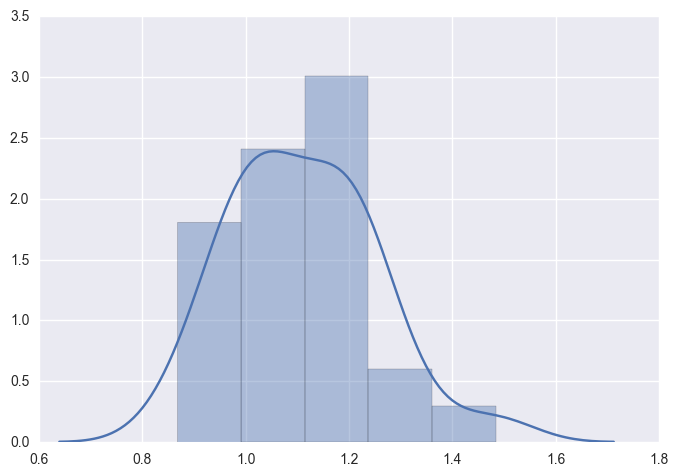

In [822]:
plt.close()
sns.distplot(tau['ctx-lh-entorhinal'].drop('MTL0550').values)
plt.show()

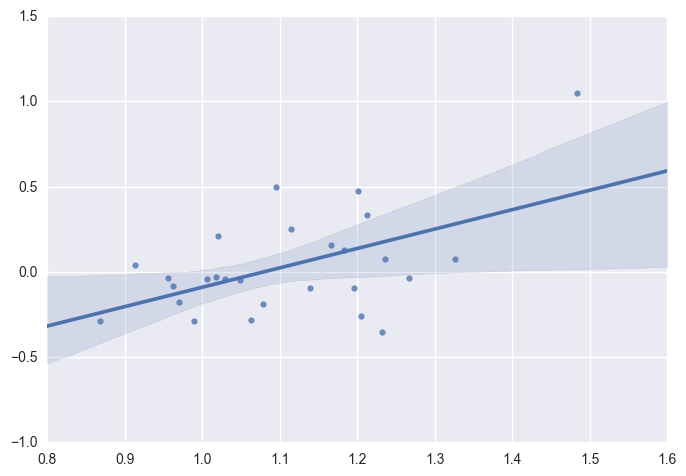

In [821]:
plt.close()
sns.regplot(tau['ctx-lh-entorhinal'].drop('MTL0550').values,
            out3.final_fa[tau.index].drop('MTL0550').values)
plt.show()

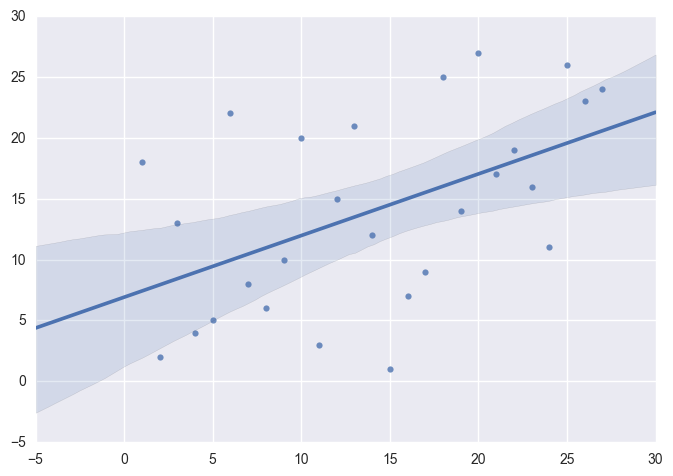

In [469]:
plt.close()
sns.regplot(stats.rankdata(tau['ctx-h-precuneus'].drop('MTL0550').values),
            stats.rankdata(out2.final_fa[tau.index].drop('MTL0550').values))
plt.show()


In [356]:
labels = pandas.read_csv('/Users/jakevogel/git/pycourse_vuMC/stuff/dst_labels.csv',header=None)

In [850]:
outcomes = pandas.concat([out2.final_fa,out3.final_fa],axis=1)
outcomes.columns = ['Outcome2','Outcome3']
outcomes
outcomes.to_excel('/Users/jakevogel/Dropbox/Work/Projects/Villeneuve_Grant_2017/Outcomes_2_and_3.xls')